In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

## Load some colormaps (if needed):

cmap_dirs = [x for x in os.listdir('/home/leachl/Downloads/ScientificColourMaps5/') if not '.' in x and not '+' in x]
cmaps = {}
for cmapname in cmap_dirs:
    cm_data = np.loadtxt('/home/leachl/Downloads/ScientificColourMaps5/'+cmapname+'/'+cmapname+'.txt')
    cmaps[cmapname] = matplotlib.colors.LinearSegmentedColormap.from_list(cmapname, cm_data)

# Get Data
## Emms; Concs; Forc; RCP; SSPs

In [2]:
# CO2 from GCP

GCP_CO2_data = pd.read_excel('/home/leachl/Documents/Datasets/Emissions/Global_carbon_budget/Global_Carbon_Budget_2018v1.0.xlsx',-1,skiprows=14,index_col=0)
GCP_CO2_data.iloc[0,:2] = 0
CO2_emms = GCP_CO2_data.interpolate(method='linear').iloc[:,:2].sum(axis=1).rename('CO2')

# CH4 from PRIMAP-hist

PRIMAP_hist=pd.read_csv('/home/leachl/Documents/Datasets/Emissions/PRIMAP-hist/PRIMAP-hist_v2.0_11-Dec-2018/PRIMAP-hist_v2.0_11-Dec-2018.csv')
CH4_emms = PRIMAP_hist.loc[(PRIMAP_hist.country == 'EARTH')&(PRIMAP_hist.scenario=='HISTTP')&(PRIMAP_hist.entity=='CH4')&(PRIMAP_hist.category=='IPCM0EL')].iloc[:,5:].T.apply(pd.to_numeric)
CH4_emms.columns = ['CH4']
CH4_emms = CH4_emms.set_index(np.arange(1850,2017)).reindex(np.arange(1750,2017))
CH4_emms.loc[:1849] = np.linspace(0,0.99,100)[:,np.newaxis] * CH4_emms.loc[1850].values

# N2O from PRIMAP_hist

N2O_emms = PRIMAP_hist.loc[(PRIMAP_hist.country == 'EARTH')&(PRIMAP_hist.scenario=='HISTTP')&(PRIMAP_hist.entity=='N2O')&(PRIMAP_hist.category=='IPCM0EL')].iloc[:,5:].T.apply(pd.to_numeric)
N2O_emms.columns = ['N2O']
N2O_emms = N2O_emms.set_index(np.arange(1850,2017)).reindex(np.arange(1750,2017))
N2O_emms.loc[:1849] = np.linspace(0,0.99,100)[:,np.newaxis] * N2O_emms.loc[1850].values

# Combine
Best_emission_estimates = pd.concat([pd.concat([CO2_emms,CH4_emms/1000,N2O_emms*28/44000],axis=1)],keys=['default'],axis=1)

In [3]:
#(linearly scaling NOAA to match CMIP6 - not by a lot)

CMIP6_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)
CMIP6_concs_extended = CMIP6_concs.loc[:,['CO2','CH4','N2O']].reindex(np.arange(1500,2019))

NOAA_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/NOAA_MoleFractions_2019.csv',skiprows=2,index_col=0)
NOAA_concs = NOAA_concs.iloc[1:-5].loc[:,['CO2','CH4','N2O']].apply(pd.to_numeric).set_index(np.arange(1979,2019))

CMIP6_concs_extended.loc[2015:] = NOAA_concs.loc[2015:] * CMIP6_concs.loc[2014,['CO2','CH4','N2O']] / NOAA_concs.loc[2014]

In [4]:
HIST_forc_PF = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=3,sep='\t',index_col=0).apply(pd.to_numeric)
HIST_forc_PF.iloc[-3:,:] = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=271,header=None,delim_whitespace=True,index_col=0).values
HIST_forc_PF = HIST_forc_PF.set_index(np.arange(1750,2020))
HIST_forc_PF['Natural total'] = HIST_forc_PF['Total'] - HIST_forc_PF['Anthro total']

In [5]:
RCP_data = {}
RCP_data['RF'] = {}
RCP_data['C'] = {}
RCP_data['E'] = {}

for RCP in ['3PD','45','6','85']:
    RCP_data['C'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0).loc[np.arange(1765,2201)]
    RCP_data['RF'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0).loc[np.arange(1765,2201)]
    RCP_data['E'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0).loc[:2200]
    RCP_data['E'][RCP]['CO2'] = RCP_data['E'][RCP][['FossilCO2','OtherCO2']].sum(axis=1)

In [6]:
## Load the IAMC db rfs ## 

#### Import the IAMC database ####

IAMC_db = pd.read_excel('/home/leachl/Documents/Datasets/IIASA_IAMC/iamc15_scenario_data_world_r2.0.xlsx',1)
IAMC_meta = pd.read_excel('/home/leachl/Documents/Datasets/IIASA_IAMC/sr15_metadata_indicators_r2.0.xlsx',1)
data_years = [str(x) for x in range(2000,2101)]

def slice_IAMC_db(Variable=False,Category=False):
    
    ## NB both kwargs must be list types even if slicing only one
    
    if not Category is False:
        
        model_scenario = IAMC_meta.loc[IAMC_meta.category.isin(Category),['model','scenario']].sum(axis=1)
        
        if Variable is False:
            
            return IAMC_db.loc[IAMC_db[['Model','Scenario']].sum(axis=1).isin(model_scenario)]
        
        else:
            
            return IAMC_db.loc[(IAMC_db[['Model','Scenario']].sum(axis=1).isin(model_scenario))&(IAMC_db.Variable.isin(Variable))]
        
    else:
        
        return IAMC_db.loc[IAMC_db.Variable.isin(Variable)]
    
def get_common_model_scenario(dfs):
    
    model_scenario_sets = []
    
    for df in dfs:
        
        model_scenario_sets += [set(df[['Model','Scenario']].sum(axis=1).unique())]
        
    common = set.intersection(*model_scenario_sets)
    
    common_dfs = []
    
    for df in dfs:
        
        common_dfs += [df.loc[df[['Model','Scenario']].sum(axis=1).isin(common)]]
        
    return common_df

## Generate gas_params

In [187]:
ALL_gas_params = pd.read_pickle('./Parameter_Sets/FaIRv2_gas-cycle-parameters_no-CH4-feedbacks_FULL-gas-suite_with_aerosols.p')

## User choices:

# Set CH4 to global methane project top-down estimate
ALL_gas_params.loc['r0',('default','CH4')] = 8.44464111328125

# Add in Halon-1202

ALL_gas_params.loc[:,('default','Halon-1202')] = np.array([1,0,0,0,2.52,1,1,1,2.52,0,0,0,1e-30,1/(5.15*209.82/28.97),0,0.27,0])

## Change SOx log forcing so ERFaci == -0.45 in 2011 with CEDS SO2 emissions

ALL_gas_params.loc['f1',('default','SOx')] = -0.419

## Remap names to be in line with SSPs:
ALL_gas_params.columns.set_levels([x.replace('-','') for x in ALL_gas_params.columns.levels[1]],level=1,inplace=True)
ALL_gas_params = ALL_gas_params.rename({'SOx':'Sulfur','NMVOC':'VOC','HFC245fa':'HFC245ca','HFC4310mee':'HFC43-10','CF4':'PFC'},axis=1,level=1)

ALL_gas_params

Gas_cycle_set         default                                        \
Gas                       CO2         CH4         N2O       HFC134a   
param_name                                                            
a1                   0.217300    1.000000    1.000000  1.000000e+00   
a2                   0.224000    0.000000    0.000000  0.000000e+00   
a3                   0.282400    0.000000    0.000000  0.000000e+00   
a4                   0.276300    0.000000    0.000000  0.000000e+00   
tau1           1000000.000000    9.150000  116.000000  1.302656e+01   
tau2               394.400000    1.000000    1.000000  1.000000e+00   
tau3                36.540000    1.000000    1.000000  1.000000e+00   
tau4                 4.304000    1.000000    1.000000  1.000000e+00   
r0                  28.627296    8.444641   67.843356  1.302052e+01   
rC                   0.019773    0.000000    0.000000  0.000000e+00   
rT                   4.334433   -0.287247    0.000000  0.000000e+00   
rA                   0.000000    0.000343   -0.000999  0.000000e+00   
PI_conc            278.000000  733.822081  271.258492  1.000000e-30   
emis2conc            0.468952    0.351714    0.200980  5.515464e-02   
f1                   5.754389    0.061736   -0.054407  0.000000e+00   
f2                   0.001215   -0.000049    0.000157  1.600000e-01   
f3                  -0.069598    0.038416    0.106208  0.000000e+00   

Gas_cycle_set                                                          \
Gas                   HFC23         HFC32        HFC125       HFC143a   
param_name                                                              
a1             1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
a2             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
a3             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
a4             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
tau1           4.245609e+02  5.003438e+00  2.845703e+01  1.101979e+02   
tau2           1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
tau3           1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
tau4           1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
r0             8.909578e+01  5.003437e+00  2.760971e+01  6.572768e+01   
rC             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
rT             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
rA             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
PI_conc        1.000000e-30  1.000000e-30  1.000000e-30  1.000000e-30   
emis2conc      8.038035e-02  1.081698e-01  4.688742e-02  6.696131e-02   
f1             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
f2             1.800000e-01  1.100000e-01  2.300000e-01  1.600000e-01   
f3             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

Gas_cycle_set                              ...                              \
Gas                 HFC152a      HFC227ea  ...     Halon1301     Halon2402   
param_name                                 ...                               
a1             1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   
a2             0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
a3             0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
a4             0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
tau1           1.515000e+00  3.436875e+01  ...  9.350156e+01  3.057812e+01   
tau2           1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   
tau3           1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   
tau4           1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   
r0             1.515000e+00  3.249578e+01  ...  6.141372e+01  2.941632e+01   
rC             0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
rT             0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
rA             0.000000e+0

## Generate thermal_params

In [116]:
## Experimental thermal model fit based on AR5 TCR / ECS values and mean CMIP6 climate feedback parameters

## Do I do some IAMC scenarios with GenIR tuned to different CMIP6 models now - to show only one model really necessary given it is sufficiently tunable?? ##

JT_params = pd.read_csv('/home/leachl/Documents/Simple_models/FaIR_v2-0/FaIR_v2-0/J_Tsutsui_params/2019-09-20_1417/parms_cmip6_20190920.csv')

JT_params = JT_params.loc[(JT_params.iloc[:,1] == 'tas')&((JT_params.iloc[:,2] == 'irm-2')|(JT_params.iloc[:,2] == 'irm-3'))]

JT_UnFaIR_params = pd.DataFrame(columns=[1,2,3],index=['d','q'])

JT_UnFaIR_params.index = JT_UnFaIR_params.index.rename('param_name')

JT_UnFaIR_params.columns = JT_UnFaIR_params.columns.rename('Box')

param_list = []

for i in JT_params.index:

    curr_params = JT_UnFaIR_params.copy()
    
    curr_params.loc['d'] = (JT_params.loc[i,'tau0':'tau2']).values
    
    curr_params.loc['q'] = (JT_params.loc[i,'a0':'a2'] / JT_params.loc[i,'lambda']).values
    
    param_list += [curr_params]
    
JT_UnFaIR_params = pd.concat(param_list, keys = JT_params.iloc[:,0]+'_'+JT_params.iloc[:,2], axis = 1)

JT_UnFaIR_params.columns = JT_UnFaIR_params.columns.rename(['CMIP6-model_IR(n)','Box'])

JT_UnFaIR_params = JT_UnFaIR_params.apply(pd.to_numeric)

JT_UnFaIR_params.loc['d',([x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-2' in x],3)] = 1.
JT_UnFaIR_params.loc['q',([x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-2' in x],3)] = 0

In [119]:
F_2x = step_forcing(2*ALL_gas_params.loc['PI_conc',('default','CO2')],ALL_gas_params.loc['PI_conc',('default','CO2')],ALL_gas_params.loc['f1':'f3',('default','CO2')].values)

# let's keep the ratio of the mid / long amplitudes the same as the tuned CMIP6 versions

d = JT_UnFaIR_params.loc['d',[x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-3' in x]].unstack().mean().values

ratios = JT_UnFaIR_params.loc['q',[x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-3' in x]].unstack().mean().values

#### SET THE ECS / TCR HERE ####
ECS_TCR = np.array([np.sqrt(2.5)/0.584, np.sqrt(2.5) ]).T 
#### This is currently set to an ECS of 3K and uses the CMIP6 mean RWF as in JT (3-box)

A = np.array([[1,1,1],1-(d/70)*(1-np.exp(-70/d))])

A[:,1] += A[:,2] * ratios[2]/ratios[1]

q_1_2 = np.linalg.inv(A[:,:2]) @ ECS_TCR / F_2x

q = np.concatenate((q_1_2,[q_1_2[1]*ratios[2]/ratios[1]]))

GIRM_thermal_params = pd.concat([pd.DataFrame(index=['d','q'],columns = [1,2,3])]*2,keys=['3_box'],axis=1).apply(pd.to_numeric)

GIRM_thermal_params.loc['d','3_box'] = d
GIRM_thermal_params.loc['q','3_box'] = q

GIRM_thermal_params

3_box                       
          1          2           3
d  0.928618  10.907831  283.037400
q  0.186574   0.230036    0.287375

## Definition to run SSPs

In [194]:
# def get_SSP_emissions(model,scenario):

model = 'IMAGE 3.0.1'
scenario = 'SSP2-45'

IAMC_db_slice = IAMC_db.loc[(IAMC_db.Model==model)&(IAMC_db.Scenario==scenario)&(IAMC_db.Variable.isin([x for x in IAMC_db.Variable.unique() if 'Emissions' in x and 'MAGICC' in x]))]
IAMC_db_slice.index = [x.split('|')[-1] for x in IAMC_db_slice.Variable]
IAMC_db_slice = IAMC_db_slice.iloc[:,5:].T.interpolate(axis=0).apply(pd.to_numeric)
IAMC_db_slice.index = np.arange(2000,2101)
IAMC_db_slice['CO2'] = IAMC_db_slice['AFOLU'] + IAMC_db_slice['Energy and Industrial Processes']
IAMC_db_slice = IAMC_db_slice[[x for x in IAMC_db_slice.columns if not x in ['AFOLU','Energy and Industrial Processes']]]

Unit_scalings = pd.Series(index=IAMC_db_slice.columns)
Unit_scalings.loc[:]=1000
Unit_scalings.loc['CO2'] = 1000*44.01/12
Unit_scalings.loc['CH4'] = 1
Unit_scalings.loc['N2O'] = 1000*44/28
Unit_scalings.loc['CO2'] = 1000*44.01/12
Unit_scalings.loc['NOx'] = (14+32) / 14
Unit_scalings.loc[['BC','CO','Sulfur','VOC','OC','NH3']] = 1

In [200]:
CMIP6_concs_rename = CMIP6_concs.copy()#.columns.set_levels([x.replace('-','') for x in CMIP6_concs.columns.levels[1]],level=1)
CMIP6_concs_rename.columns = [x.replace('-','') for x in CMIP6_concs.columns]
CMIP6_concs_rename = CMIP6_concs_rename.rename({'HFC245fa':'HFC245ca','HFC4310mee':'HFC43-10','CF4':'PFC'},axis=1,level=1)

Index(['CO2', 'CH4', 'N2O', 'HFC134a', 'HFC23', 'HFC32', 'HFC125', 'HFC143a',
       'HFC152a', 'HFC227ea', 'HFC236fa', 'HFC245fa', 'HFC365mfc',
       'HFC4310mee', 'NF3', 'SF6', 'SO2F2', 'CF4', 'C2F6', 'C3F8', 'C4F10',
       'C5F12', 'C6F14', 'C7F16', 'C8F18', 'cC4F8', 'CFC12', 'CFC11', 'CFC113',
       'CFC114', 'CFC115', 'HCFC22', 'HCFC141b', 'HCFC142b', 'CH3CCl3', 'CCl4',
       'CH3Cl', 'CH2Cl2', 'CHCl3', 'CH3Br', 'Halon1211', 'Halon1301',
       'Halon2402', 'CFC12eq', 'HFC134aeq', 'CFC11eq'],
      dtype='object')

In [ ]:
## Generate gas_param_uncertainty

-1.1844037720883198
-0.4486129732035916
0.00819147506110692


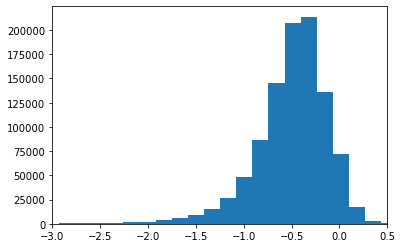

In [115]:
forc_param = np.random.normal(-0.419,0.419/1.645,1000)[:,np.newaxis]
PI_conc = np.random.normal(60,30,1000)[np.newaxis,:]

while sum(sum(PI_conc<0))>0:
    PI_conc[PI_conc<0] = np.random.normal(60,30,sum(sum(PI_conc<0)))

distr = (forc_param*np.log(115.5/PI_conc+1)).flatten()

a = plt.hist(distr,bins=50)
plt.xlim(-3,0.5)

print(np.percentile(distr,5))
print(np.percentile(distr,50))
print(np.percentile(distr,95))

In [206]:
RCP_data = {}
RCP_data['RF'] = {}
RCP_data['C'] = {}
RCP_data['E'] = {}

for RCP in ['3PD','45','6','85']:
    RCP_data['C'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0).loc[np.arange(1765,2151)]
    RCP_data['RF'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    RCP_data['E'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0).loc[:2150]